Import packages

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import dython as dy
from os.path import join
import scipy.io.wavfile as wav
import librosa as lbr
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
import csv

Spectrometer function

In [12]:
def spect(arr, fs, n_sub_r,n_sub_c):
    spect_list = []
    for i in range(0,len(arr)):
        spectrum, freq, time, im = plt.specgram(x=arr[i], Fs=fs[i],scale='dB')
        spect_split1 = np.array_split(spectrum, n_sub_r, axis=0)
        tmp_row = []
        for row in spect_split1:
            spect_split2 = np.array_split(row, n_sub_c, axis=1)
            for block in spect_split2:
                tmp_row.append(block.mean())
        spect_list.append(tmp_row)
        print(i)
    print(np.array(spect_list).shape)
    return spect_list

def spect1(arr, fs, n_sub_r,n_sub_c):
    spect_list = []
    i=0
    for audio in arr:
        spectrum, freq, time, im = plt.specgram(x=audio, Fs=fs,scale='dB')
        spect_split1 = np.array_split(spectrum, n_sub_r, axis=0)
        tmp_row = []
        for row in spect_split1:
            spect_split2 = np.array_split(row, n_sub_c, axis=1)
            for block in spect_split2:
                tmp_row.append(block.mean())
        spect_list.append(tmp_row)
        print(i)
        i+=1
    print(np.array(spect_list).shape)
    return spect_list

In [34]:
def data_import(path,par='dev'):
    df_in = pd.read_csv(path)
    df_in = df_in.rename(columns={'Self-reported fluency level ': 'fluency', 'First Language spoken': 'firstLan', 'Current language used for work/school': 'currentLan'})
    df_out = df_in[['fluency','gender','currentLan']]
    X = []
    y = []
    rate_list = []

    for item in df_in.iterrows():
        filename = item[1]['path']
        rate, data = wav.read(filename)
        rate_list.append(rate)
        X.append(data)
        if par=='dev':
            label = item[1]['action']+item[1]['object']
            y.append(label)

    if par=='dev':
        return df_out,X,y,rate_list
    else:
        return df_out,X,rate_list

def data_import1(path,par='dev'):
    df_in = pd.read_csv(path)

    X = []
    y = []
    i=0
    for item in df_in.iterrows():
        filename = item[1]['path']
        data, rate = lbr.load(filename,sr=8000)
        X.append(data)
        if par=='dev':
            label = item[1]['action']+item[1]['object']
            y.append(label)
        print(i)
        i+=1

    if par=='dev':
        return X,y
    else:
        return X

Import data

In [35]:
df_dev,X_dev_list,y_dev_list,rate_dev= data_import('development.csv','dev')
df_ev,X_ev_list,rate_ev = data_import('evaluation.csv','ev')

print(len(X_dev_list))
print(len(X_ev_list))

9854
1455


Pre-processing

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


C:\POLI\4 ANNO\SEMESTRE 1\DATA SCIENCE LAB\LAB\PROJECT\venv\lib\site-packages\matplotlib\axes\_axes.py:7720: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
2

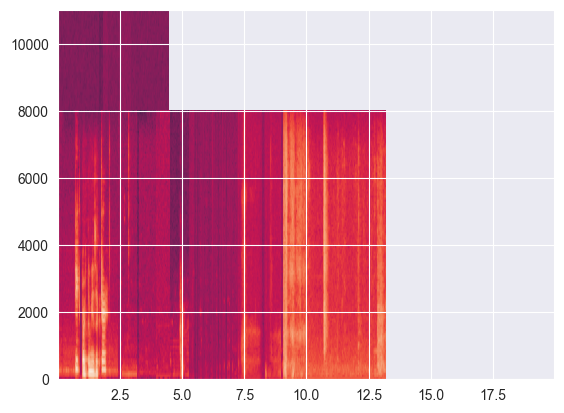

In [15]:
n_sub_row = 15
n_sub_col = 10

spectX_dev_list = spect(X_dev_list,rate_dev, n_sub_row, n_sub_col)
print('Spectrometer conversion X_dev: DONE')
spectX_ev_list = spect(X_ev_list, rate_ev, n_sub_row, n_sub_col)
print('Spectrometer conversion X_ev: DONE')

y_dev = pd.DataFrame(np.array(y_dev_list).transpose())
X_dev = pd.DataFrame(spectX_dev_list).fillna(0)
X_ev = pd.DataFrame(spectX_ev_list).fillna(0)
print('Dataframe conversion: DONE')
X_dev = normalize(X_dev)
X_ev = normalize(X_ev)
print('Normalization: DONE')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9854 entries, 0 to 9853
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       9854 non-null   float64
 1   1       9854 non-null   float64
 2   2       9854 non-null   float64
 3   3       9854 non-null   float64
 4   4       9854 non-null   float64
 5   5       9854 non-null   float64
 6   6       9854 non-null   float64
 7   7       9854 non-null   float64
 8   8       9854 non-null   float64
 9   9       9854 non-null   float64
 10  10      9854 non-null   float64
 11  11      9854 non-null   float64
 12  12      9854 non-null   float64
 13  13      9854 non-null   float64
 14  14      9854 non-null   float64
 15  15      9854 non-null   float64
 16  16      9854 non-null   float64
 17  17      9854 non-null   float64
 18  18      9854 non-null   float64
 19  19      9854 non-null   float64
 20  20      9854 non-null   float64
 21  21      9854 non-null   float64
 22  

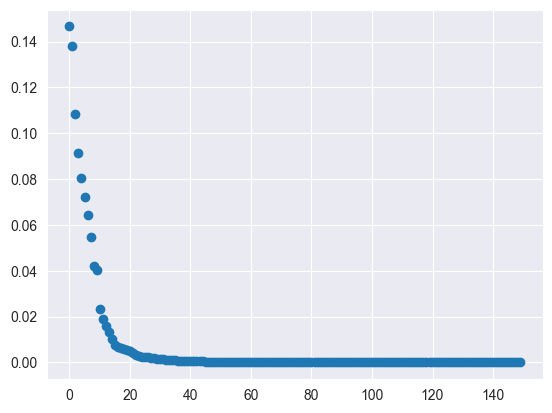

In [43]:
tot_attr = n_sub_row*n_sub_col
max_attr = 30
pca = PCA(n_components=tot_attr)
X_proj = pca.fit_transform(X_dev)
plt.plot(pca.explained_variance_ratio_, marker='o', linestyle='')

pca = PCA(n_components=max_attr)
X_dev_proj = pca.fit_transform(X_dev)
X_ev_proj = pca.transform(X_ev)
X_dev_proj=pd.DataFrame(X_dev_proj)
print(X_dev_proj.info())

In [54]:
ohe = OneHotEncoder(sparse=False, dtype=int)
df_ohe_dev = ohe.fit_transform(df_dev)
df_ohe_dev = pd.DataFrame(df_ohe_dev)
for elem in df_ohe_dev.columns:
    X_dev_proj[elem+max_attr]=df_ohe_dev[elem]
print(df_ohe_dev.info())

print(X_dev_proj.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9854 entries, 0 to 9853
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       9854 non-null   int32
 1   1       9854 non-null   int32
 2   2       9854 non-null   int32
 3   3       9854 non-null   int32
 4   4       9854 non-null   int32
 5   5       9854 non-null   int32
 6   6       9854 non-null   int32
 7   7       9854 non-null   int32
 8   8       9854 non-null   int32
 9   9       9854 non-null   int32
dtypes: int32(10)
memory usage: 385.0 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9854 entries, 0 to 9853
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       9854 non-null   float64
 1   1       9854 non-null   float64
 2   2       9854 non-null   float64
 3   3       9854 non-null   float64
 4   4       9854 non-null   float64
 5   5       9854 non-null   float64
 6   6       9854 non-nu

C:\POLI\4 ANNO\SEMESTRE 1\DATA SCIENCE LAB\LAB\PROJECT\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [55]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X_dev_proj, y_dev, test_size=0.2)

Grid-search

In [57]:
params = {
    "n_estimators": [50, 100, 200, 500],
    "criterion": ["gini", "entropy"]
}

n = 5
kf = KFold(n)
for config in ParameterGrid(params):
    sum1 = 0
    sum2 = 0
    for train_indices, validation_indices in kf.split(X_train_valid):
        X_train = X_train_valid.iloc[train_indices,:]
        X_valid = X_train_valid.iloc[validation_indices,:]
        y_train = (y_train_valid.values.ravel())[train_indices]
        y_valid = (y_train_valid.values.ravel())[validation_indices]
        rf = RandomForestClassifier(**config)
        rf.fit(X_train, y_train)
        y_prev = rf.predict(X_valid)
        score1 = f1_score(y_true=y_valid, y_pred=y_prev,average='macro')
        score2 = accuracy_score(y_true=y_valid, y_pred=y_prev)
        sum1 += score1
        sum2 += score2
    print(float(sum1 / n), float(sum2 / n), " -> ", config)


0.3069069843517006 0.37219355648616376  ->  {'criterion': 'gini', 'n_estimators': 50}
0.30930027423974454 0.3781549655742929  ->  {'criterion': 'gini', 'n_estimators': 100}
0.3160757797129999 0.3855119113912235  ->  {'criterion': 'gini', 'n_estimators': 200}
0.31569626703504444 0.3905871683367185  ->  {'criterion': 'gini', 'n_estimators': 500}
0.31311642906082915 0.37548974954050773  ->  {'criterion': 'entropy', 'n_estimators': 50}
0.318827131042169 0.3815795911404099  ->  {'criterion': 'entropy', 'n_estimators': 100}
0.31792374536656826 0.38627309129652454  ->  {'criterion': 'entropy', 'n_estimators': 200}


KeyboardInterrupt: 

Test

In [10]:
rf = RandomForestClassifier(n_estimators=500, criterion='entropy')
rf.fit(X_train_valid, y_train_valid.values.ravel())
y_prev = rf.predict(X_test)
score1 = f1_score(y_true=y_test, y_pred=y_prev, average='macro')
score2 = accuracy_score(y_true=y_test, y_pred=y_prev)
print(score1," - ",score2)

0.4702236746824857  -  0.4911212582445459


Evaluation

In [ ]:
rf = RandomForestClassifier(n_estimators=500, criterion='entropy')
rf.fit(X_dev, y_dev.values.ravel())
y_prev_ev = rf.predict(X_ev)

Generate results

In [ ]:
with open('res.csv', mode='w', newline='') as file:
    file_writer = csv.writer(file)
    i = 0
    file_writer.writerow(['Id', 'Predicted'])
    for elem in y_prev_ev:
        file_writer.writerow([i, elem])
        i += 1